In [63]:
from dataclasses import dataclass

import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import TargetEncoder, StandardScaler, LabelEncoder
from sklearn.metrics import root_mean_squared_error as RMSE
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
# filter warnings
warnings.filterwarnings('ignore')



In [64]:
import os

# 1. Перевіряємо, в якій папці зараз працює ноутбук
print(os.getcwd())
print(os.listdir())  # тут має бути видно 'Module_2_Lecture_2_Class_penguins.csv'

# 2. Читаємо файл з цієї ж директорії
path = "Module_2_Lecture_2_Class_penguins.csv"
df = pd.read_csv(path)

df.sample(5, random_state=42)


c:\Users\Nolan\Documents\My dokuments\GoIT\Deep_learning\topic_3_4
['Class_penguins..ipynb', 'HW4', 'lecture_3.ipynb', 'log_regr.ipynb', 'Module_2_Lecture_2_Class_penguins.csv', 'Spaceship_Titanic.ipynb']


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
194,Gentoo,Biscoe,45.3,13.7,210.0,4300.0,female
157,Gentoo,Biscoe,46.5,13.5,210.0,4550.0,female
225,Gentoo,Biscoe,46.5,14.8,217.0,5200.0,female
208,Gentoo,Biscoe,43.8,13.9,208.0,4300.0,female
318,Chinstrap,Dream,50.9,19.1,196.0,3550.0,male


## EDA

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


In [66]:
df = df.dropna().reset_index(drop=True)

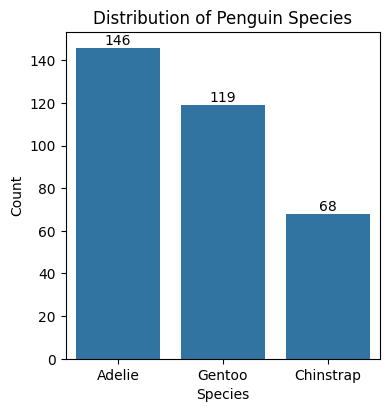

In [67]:
# Розподіл цільової змінної
plt.figure(figsize=(4, 4))
ax = sns.countplot(data=df, x='species')
for i in ax.containers:
    ax.bar_label(i)
    ax.set_ylabel('Count')
    ax.set_xlabel('Species')
plt.tight_layout()
plt.title('Distribution of Penguin Species')
plt.show()

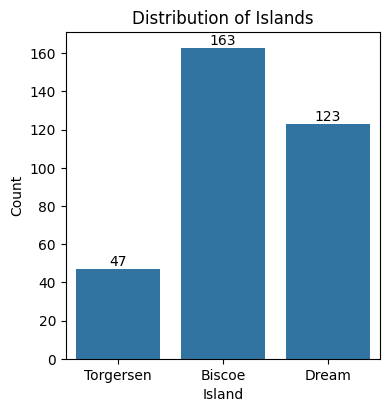

In [68]:
# ПОдивимося розподіл зміннох island
plt.figure(figsize=(4, 4))
ax = sns.countplot(data=df, x='island')
for i in ax.containers:
    ax.bar_label(i)
    ax.set_ylabel('Count')
    ax.set_xlabel('Island')
plt.tight_layout()
plt.title('Distribution of Islands')
plt.show()

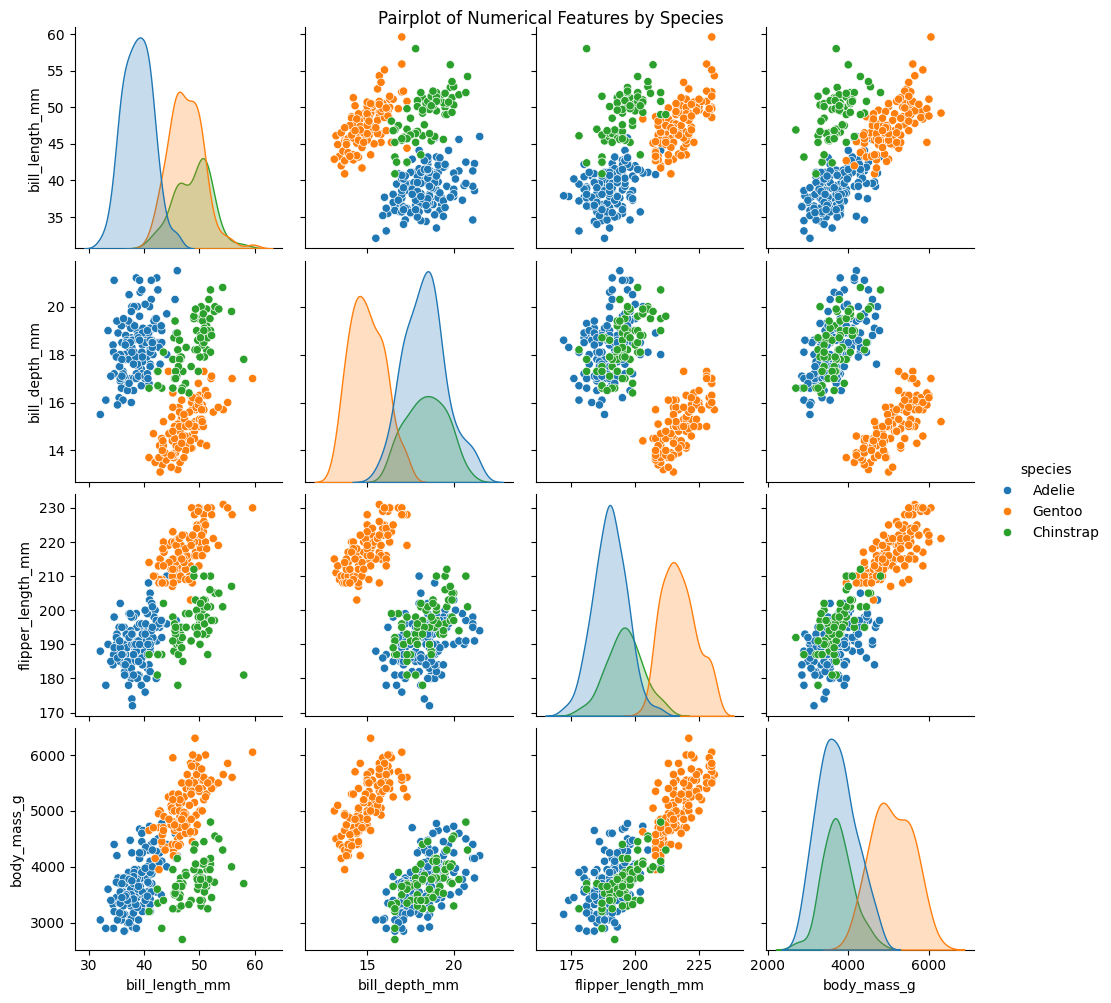

In [69]:
# Подивимось на попарний розподіл числових ознак.
sns.pairplot(df, hue='species').fig.suptitle('Pairplot of Numerical Features by Species', y=1)
plt.show()

In [70]:
# Для моделювання цієї задачі залишимо тільки числові змінні.
features = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
df = df.loc[:, features + ['species']]
df.sample(5, random_state=42)

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,species
25,39.5,16.7,178.0,3250.0,Adelie
309,50.9,17.9,196.0,3675.0,Chinstrap
73,42.1,19.1,195.0,4000.0,Adelie
195,46.6,14.2,210.0,4850.0,Gentoo
57,41.1,18.2,192.0,4050.0,Adelie


In [71]:
df.loc[df['species'] == 'Adelie', 'species'] = 0
df.loc[df['species'] == 'Chinstrap', 'species'] = 1
df.loc[df['species'] == 'Gentoo', 'species'] = 2
df['species'] = df['species'].astype(int)
df.sample(5, random_state=42)

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,species
25,39.5,16.7,178.0,3250.0,0
309,50.9,17.9,196.0,3675.0,1
73,42.1,19.1,195.0,4000.0,0
195,46.6,14.2,210.0,4850.0,2
57,41.1,18.2,192.0,4050.0,0


## Training

In [72]:
X = df.drop('species', axis=1)
y = df['species']

scaler = StandardScaler()
X = scaler.fit_transform(X)
X

array([[-0.89604189,  0.7807321 , -1.42675157, -0.56847478],
       [-0.82278787,  0.11958397, -1.06947358, -0.50628618],
       [-0.67627982,  0.42472926, -0.42637319, -1.1903608 ],
       ...,
       [ 1.02687621,  0.52644436, -0.56928439, -0.53738048],
       [ 1.24663828,  0.93330475,  0.64546078, -0.13315457],
       [ 1.13675725,  0.7807321 , -0.2120064 , -0.53738048]],
      shape=(333, 4))

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train = torch.tensor(X_train, dtype=torch.float)
X_test = torch.tensor(X_test, dtype=torch.float)
y_train = torch.tensor(y_train.values, dtype=torch.long)
y_test = torch.tensor(y_test.values, dtype=torch.long)

print(X_train, "\n\n")
print(X_train[:1], "\n\n")
print(y_train, "\n\n")
print(y_train[:10], "\n\n")

tensor([[ 0.1661, -1.9656,  0.8598,  1.1106],
        [ 1.2283,  1.2893,  0.1453, -0.1953],
        [ 0.8804, -0.4907,  1.5029,  2.2300],
        ...,
        [ 0.0196,  1.2893, -0.3549,  0.2400],
        [ 0.8071, -0.4398,  1.3600,  1.4837],
        [-1.9216,  0.9333, -0.7837, -0.7550]]) 


tensor([[ 0.1661, -1.9656,  0.8598,  1.1106]]) 


tensor([2, 1, 2, 0, 0, 2, 2, 0, 0, 2, 0, 2, 1, 1, 0, 1, 2, 0, 2, 1, 0, 0, 0, 2,
        0, 2, 2, 1, 2, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 2, 2,
        0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 0, 2, 2,
        0, 0, 2, 0, 2, 2, 2, 0, 1, 1, 2, 0, 2, 1, 2, 0, 2, 0, 2, 0, 1, 2, 1, 0,
        0, 0, 1, 1, 1, 2, 2, 0, 0, 2, 2, 1, 2, 1, 2, 0, 2, 2, 0, 0, 2, 0, 2, 0,
        0, 1, 1, 1, 2, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 2, 0, 0, 2, 0, 2, 2, 0, 2,
        1, 1, 2, 0, 2, 2, 2, 2, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 2, 0, 2,
        0, 0, 2, 2, 2, 2, 2, 1, 1, 0, 2, 0, 2, 2, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
        2, 0, 0, 

In [74]:
class LinearModel(nn.Module):
    def __init__(self, in_dim, hidden_dim=20, out_dim=3):
        super().__init__()
        self.features = torch.nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim),
            nn.Softmax()
        )
    def forward(self, x):
        x = self.features(x)
        return x

In [75]:
model = LinearModel(X_train.shape[1], hidden_dim=20, out_dim=3 )
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
num_epoch = 600

train_loss = []
test_loss = []

train_accs = []
test_accs = []

In [76]:
# Training
for epoch in range(num_epoch):
    model.train()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    train_loss.append(loss.cpu().detach().numpy())

    # Backward pass and optimization
    optimizer.zero_grad()    
    loss.backward()
    optimizer.step()

    # Calculate training accuracy
    acc = 100 * torch.sum(y_train==torch.max(outputs.data, 1)[1]).double() / len(y_train)
    train_accs.append(acc)

    if (epoch+1) % 50 == 0:
        print ('Epoch [%d/%d] Loss: %.4f   Acc: %.2f' 
                       %(epoch+1, num_epoch, loss.item(), acc.item()))
        
    # Evaluation on test set
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        
        loss = criterion(outputs, y_test)
        test_loss.append(loss.cpu().detach().numpy())
        
        acc = 100 * torch.sum(y_test==torch.max(outputs.data, 1)[1]).double() / len(y_test)
        test_accs.append(acc)



Epoch [50/600] Loss: 0.9865   Acc: 77.82
Epoch [100/600] Loss: 0.9544   Acc: 78.57
Epoch [150/600] Loss: 0.9224   Acc: 78.95
Epoch [200/600] Loss: 0.8913   Acc: 78.95
Epoch [250/600] Loss: 0.8625   Acc: 79.70
Epoch [300/600] Loss: 0.8368   Acc: 80.08
Epoch [350/600] Loss: 0.8146   Acc: 80.08
Epoch [400/600] Loss: 0.7957   Acc: 80.45
Epoch [450/600] Loss: 0.7798   Acc: 80.83
Epoch [500/600] Loss: 0.7664   Acc: 81.20
Epoch [550/600] Loss: 0.7550   Acc: 82.33
Epoch [600/600] Loss: 0.7452   Acc: 83.46


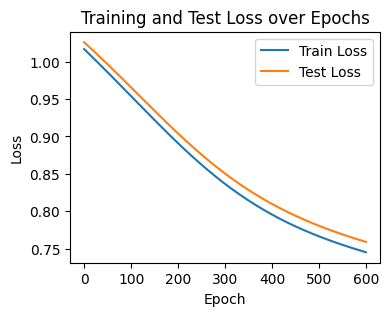

In [77]:
plt.figure(figsize=(4, 3))
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss over Epochs')
plt.legend()
plt.show()


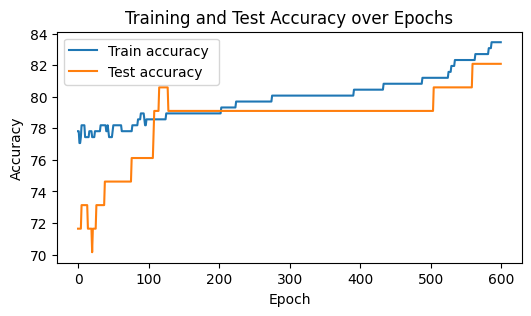

In [79]:
plt.figure(figsize=(6, 3))
plt.plot(train_accs, label='Train accuracy ')
plt.plot(test_accs, label='Test accuracy ')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy over Epochs')
plt.legend()
plt.show()